### **Section 1: Data Prep**

In [1]:
!pip install m2cgen

#### **1.1 Data Loading**

In [2]:
# Install the Updated Version of SKLearn if Nedded
!pip install scikit-learn==0.24.2

^C
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1


In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from PIL import Image as im
import sys
sys.setrecursionlimit(2147483647)
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
style.use("ggplot")


In [2]:


# Load Training Data and Evaluation Data.
def data_prep_multiclass(path_prefix, class_idx):
    results = []
    for name in ["eval", "train"]:
        csv = pd.read_csv(f"{path_prefix}{name}.csv")
        csv = csv.iloc[:, 0:258]
        csv.dropna(inplace=True)
        csv.drop_duplicates(inplace=True)
        csv.drop(csv[(csv['label'] != 0) & (csv['label'] != class_idx)].index, inplace = True)

        csv.reset_index(drop=True,inplace=True)
        
        for i in range(len(csv)):
            if csv['label'][i] != 0: csv['label'][i] = 1
    
        results.append(csv)
    return results

def data_prep_binary(path_prefix):
    results = []
    for name in ["eval", "train"]:
        csv = pd.read_csv(f"{path_prefix}{name}.csv")
        csv = csv.iloc[:, 0:258]
        csv.dropna(inplace=True)
        csv.drop_duplicates(inplace=True)
        csv.reset_index(drop=True,inplace=True)
        
        for i in range(len(csv)):
            if csv['label'][i] != 0: csv['label'][i] = 1
    
        results.append(csv)
    return results

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, random_split
from torchvision import transforms
from PIL import Image

transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

train_csv, eval_csv = data_prep_binary("data/1126")

class PandasDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.transform = transform
        self.dataframe = dataframe
        self.labels = self.dataframe.label.to_numpy().astype(float)
        self.data = self.dataframe.iloc[:, 1:257].to_numpy()
        self.data = (self.data - self.data.mean(1, keepdims=True)) / (self.data.std(1, keepdims=True) + 1e-8)
        self.data = self.data.reshape(-1, 1, 16, 16).astype(float)
        print(self.labels.shape)
        print(self.data.shape)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img = self.data[index, ...]
        if self.transform:
            img = self.transform(Image.fromarray(img[0, ...]))
        target = float(self.labels[index])
        return img, target

batch_size_train = 1280
batch_size_test = 1280
total_size  = len(train_csv)
train_size = int(total_size * 0.8)
test_size = total_size - train_size
# train_dataset, test_dataset = random_split(PandasDataset(train_csv, transform=transforms),
train_dataset, test_dataset = random_split(PandasDataset(train_csv, transform=None),
                                           [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)
eval_loader = torch.utils.data.DataLoader(PandasDataset(eval_csv,transform=None), 
                                          batch_size=len(eval_csv), shuffle=False)
train_csv.label.unique()

(3565,)
(3565, 1, 16, 16)
(35166,)
(35166, 1, 16, 16)


array([0., 1.])

torch.Size([1280, 1, 16, 16])
torch.Size([1280])


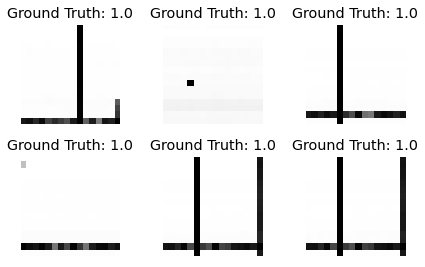

In [4]:
examples = enumerate(train_loader)
idx, example_data = next(examples)
imgs, labels = example_data
print(imgs.shape)
print(labels.shape)
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(imgs[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(labels[i]))
  plt.xticks([])
  plt.yticks([])

#### **2.2 NN Training**

In [5]:
class TwoDCNN(nn.Module):
  def __init__(self, config=[1, 4, 8, 16, 32], dropout=0.5):
    super(TwoDCNN, self).__init__()
    
    modules = []
    for i, dim in enumerate(config[1:-1]):
      modules += [
        nn.Conv2d(config[i], dim, 3, padding=1),
        nn.LeakyReLU(),
        nn.BatchNorm2d(dim),
        nn.Dropout(dropout),
        nn.MaxPool2d(2)
      ]
    modules += [
      nn.Conv2d(config[-2], config[-1], 3, padding=1),
      # nn.LeakyReLU(),
      nn.BatchNorm2d(config[-1]),
      nn.AdaptiveAvgPool2d((1, 1)),
      nn.Flatten(),
      nn.Linear(config[-1], 1),
      nn.Sigmoid()
    ]
    self.net = nn.Sequential(*modules)
    

  def forward(self, x):
    for layer in self.net:
        x = layer(x)
    return x.reshape(-1)

criterion = nn.BCELoss()

In [6]:
import torch
import torch.nn as nn

from einops import rearrange


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


def conv_nxn_bn(inp, oup, kernal_size=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernal_size, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.SiLU()
    )


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.SiLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        return self.net(x)


class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b p n (h d) -> b p h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b p h n d -> b p n (h d)')
        return self.to_out(out)


class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads, dim_head, dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout))
            ]))
    
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


class MV2Block(nn.Module):
    def __init__(self, inp, oup, stride=1, expansion=4):
        super().__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expansion)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.SiLU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileViTBlock(nn.Module):
    def __init__(self, dim, depth, channel, kernel_size, patch_size, mlp_dim, dropout=0.):
        super().__init__()
        self.ph, self.pw = patch_size

        self.conv1 = conv_nxn_bn(channel, channel, kernel_size)
        self.conv2 = conv_1x1_bn(channel, dim)

        self.transformer = Transformer(dim, depth, 1, 32, mlp_dim, dropout)

        self.conv3 = conv_1x1_bn(dim, channel)
        self.conv4 = conv_nxn_bn(2 * channel, channel, kernel_size)
    
    def forward(self, x):
        y = x.clone()

        # Local representations
        x = self.conv1(x)
        x = self.conv2(x)
        
        # Global representations
        _, _, h, w = x.shape
        x = rearrange(x, 'b d (h ph) (w pw) -> b (ph pw) (h w) d', ph=self.ph, pw=self.pw)
        x = self.transformer(x)
        x = rearrange(x, 'b (ph pw) (h w) d -> b d (h ph) (w pw)', h=h//self.ph, w=w//self.pw, ph=self.ph, pw=self.pw)

        # Fusion
        x = self.conv3(x)
        x = torch.cat((x, y), 1)
        x = self.conv4(x)
        return x



In [7]:
# our mobilevit
class TFTwoDCNN(nn.Module):
  def __init__(self, config=[1, 4, 8, 16, 16], maxpool=[True, True, True], dropout=0.5):
    super(TFTwoDCNN, self).__init__()
    
    modules = []
    for i, dim in enumerate(config[1:-1]):
      modules += [
        nn.Conv2d(config[i], dim, 3, padding=1),
        nn.LeakyReLU(),
        nn.BatchNorm2d(dim),
        nn.Dropout(dropout)
      ]
      if maxpool[i]:
        modules += [nn.MaxPool2d(2)]
      modules += [MobileViTBlock(dim, 2, dim, 3, (2, 2), dim*3)]
    modules += [
      nn.Conv2d(config[-2], config[-1], 3, padding=1),
      nn.BatchNorm2d(config[-1]),
      nn.AdaptiveAvgPool2d((1, 1)),
      nn.Flatten(),
      nn.Linear(config[-1], 1),
      nn.Sigmoid()
    ]
    self.net = nn.Sequential(*modules)
    

  def forward(self, x):
    for layer in self.net:
        x = layer(x)
    return x.reshape(-1)

criterion = nn.BCELoss()


In [8]:
def test_eval(model, test_loader, eval_loader):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.eval()
  acc = {}
  with torch.no_grad():
    # for name, loader in [("test", test_loader), ("eval", eval_loader)]:
    for name, loader in [("test", test_loader)]:
      correct_count, all_count = 0, 0
      for images, labels in loader:
        images = images.type(torch.float).to(device)
        labels = labels.type(torch.float).to(device)
        out = model(images)
        pred = out > 0.5
        correct_count += (labels == pred).sum().item()
        all_count += images.shape[0]
      acc[name] = correct_count / all_count
      print(f"On %s set: Acc %.3f" % (
        name, acc[name]))
  # return acc["test"], acc["eval"]
  return acc["test"], 0

def train(model, train_loader, test_loader, eval_loader, epochs, lr):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = model.to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
  eval_acc_list = []
  test_acc_list = []
  train_acc_list = []
  for e in range(epochs):
    model.train()
    running_loss = 0
    ct, all_count = 0, 0
    for images, labels in train_loader:
      optimizer.zero_grad()
      images = images.type(torch.float).to(device)
      labels = labels.type(torch.float).to(device)
      output = model(images)
      loss = criterion(output, labels)
      pred = output > 0.5
      ct += (labels == pred).sum().item()
      all_count += images.shape[0]
      loss.backward()

      optimizer.step()
      ct += 1
      running_loss += loss.item()
    train_acc_list.append(ct / all_count)
    print("Epoch {} - Training loss: {:.3f}".format(e+1, running_loss/len(train_loader)))
    print(f"On train set: Acc %.3f" % (ct / all_count))
    test_acc, eval_acc = test_eval(model, test_loader, eval_loader)
    eval_acc_list.append(test_acc)
    test_acc_list.append(eval_acc)
  print(f"Best Train Acc: {max(train_acc_list)}")
  print(f"Best Test Acc: {max(eval_acc_list)}")
  # print(f"Best Eval Acc: {max(test_acc_list)}")


In [9]:
model = TwoDCNN(dropout=0.01)
train(model, train_loader, test_loader, eval_loader, 80, 0.05)

D:\anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1 - Training loss: 0.721
On train set: Acc 0.519
On test set: Acc 0.750
Epoch 2 - Training loss: 0.476
On train set: Acc 0.859
On test set: Acc 0.875
Epoch 3 - Training loss: 0.329
On train set: Acc 0.860
On test set: Acc 0.896
Epoch 4 - Training loss: 0.253
On train set: Acc 0.899
On test set: Acc 0.886
Epoch 5 - Training loss: 0.218
On train set: Acc 0.907
On test set: Acc 0.907
Epoch 6 - Training loss: 0.196
On train set: Acc 0.928
On test set: Acc 0.895
Epoch 7 - Training loss: 0.175
On train set: Acc 0.930
On test set: Acc 0.912
Epoch 8 - Training loss: 0.157
On train set: Acc 0.940
On test set: Acc 0.912
Epoch 9 - Training loss: 0.147
On train set: Acc 0.946
On test set: Acc 0.916
Epoch 10 - Training loss: 0.130
On train set: Acc 0.954
On test set: Acc 0.917
Epoch 11 - Training loss: 0.098
On train set: Acc 0.959
On test set: Acc 0.896
Epoch 12 - Training loss: 0.109
On train set: Acc 0.971
On test set: Acc 0.916
Epoch 13 - Training loss: 0.118
On train set: Acc 0.971
On te

In [10]:
model = TFTwoDCNN(dropout=0.01)
train(model, train_loader, test_loader, eval_loader, 120, 0.05)

Epoch 1 - Training loss: 0.749
On train set: Acc 0.492
On test set: Acc 0.760
Epoch 2 - Training loss: 0.579
On train set: Acc 0.690
On test set: Acc 0.760
Epoch 3 - Training loss: 0.517
On train set: Acc 0.748
On test set: Acc 0.760
Epoch 4 - Training loss: 0.432
On train set: Acc 0.777
On test set: Acc 0.760
Epoch 5 - Training loss: 0.414
On train set: Acc 0.789
On test set: Acc 0.760
Epoch 6 - Training loss: 0.324
On train set: Acc 0.837
On test set: Acc 0.760
Epoch 7 - Training loss: 0.335
On train set: Acc 0.842
On test set: Acc 0.760
Epoch 8 - Training loss: 0.281
On train set: Acc 0.867
On test set: Acc 0.760
Epoch 9 - Training loss: 0.253
On train set: Acc 0.885
On test set: Acc 0.760
Epoch 10 - Training loss: 0.227
On train set: Acc 0.913
On test set: Acc 0.759
Epoch 11 - Training loss: 0.203
On train set: Acc 0.917
On test set: Acc 0.742
Epoch 12 - Training loss: 0.197
On train set: Acc 0.917
On test set: Acc 0.750
Epoch 13 - Training loss: 0.208
On train set: Acc 0.920
On te